In [1]:
import time
import pandas as pd
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
patterns_path =  'patterns.csv'   # the file name that will store the frequent patterns
maximal_path =   'maximal.csv'
rules_path =     'rules.csv'
datasetFile = open("project.dataset1.txt", "r")
listOfItems = []
frequency = []
for line in datasetFile:
    strippedLine = line.strip()
    lineList = strippedLine.split()
    listOfItems.append(lineList)
    frequency.append(1)

datasetFile.close()

numberOfTransaction = len(listOfItems)
min_support =     0.0015            # minimuum support threshold which is in percentage format (for example 0.2 means 20%)
min_confidence =  0.9             # the minimum confidence threshold in the percentage format

In [3]:
class Node:
    def __init__(self, itemName, frequency, parentNode):
        self.itemName = itemName
        self.count = frequency
        self.parent = parentNode
        self.children = {}
        self.next = None

    def increment(self, frequency):
        self.count += frequency
    def display(self, ind=1):
        print('  ' * ind, self.itemName, ' ', self.count)
        for child in list(self.children.values()):
            child.display(ind + 1)


def updateHeaderTable(item, targetNode, headerTable):
    if (headerTable[item][1] == None):
        headerTable[item][1] = targetNode
    else:
        currentNode = headerTable[item][1]
        # Traverse to the last node then link it to the target
        while currentNode.next != None:
            currentNode = currentNode.next
        currentNode.next = targetNode

def updateTree(item, treeNode, headerTable, frequency):
    if item in treeNode.children:
        # If the item already exists, increment the count
        treeNode.children[item].increment(frequency)
    else:
        # Create a new branch
        newItemNode = Node(item, frequency, treeNode)
        treeNode.children[item] = newItemNode
        # Link the new branch to header table
        updateHeaderTable(item, newItemNode, headerTable)

    return treeNode.children[item]

def constructTree(itemSetList, frequency, minSup):
    headerTable = defaultdict(int)
    # Counting frequency and create header table
    for idx, itemSet in enumerate(itemSetList):
        for item in itemSet:
            headerTable[item] += frequency[idx]

    # Deleting items below minSup
    headerTable = dict((item, sup) for item, sup in headerTable.items() if sup >= minSup)
    if (len(headerTable) == 0):
        return None, None

    # HeaderTable column [Item: [frequency, headNode]]
    for item in headerTable:
        headerTable[item] = [headerTable[item], None]

    # Init Null head node
    fpTree = Node('Null', 1, None)
    # Update FP tree for each cleaned and sorted itemSet
    for idx, itemSet in enumerate(itemSetList):
        itemSet = [item for item in itemSet if item in headerTable]
        itemSet.sort(key=lambda item: headerTable[item][0], reverse=True)
        # Traverse from root to leaf, update tree with given item
        currentNode = fpTree
        for item in itemSet:
            currentNode = updateTree(item, currentNode, headerTable, frequency[idx])

    return fpTree, headerTable

def ascendFPtree(node, prefixPath):
    if node.parent != None:
        prefixPath.append(node.itemName)
        ascendFPtree(node.parent, prefixPath)


def findPrefixPath(basePat, headerTable):
    # First node in linked list
    treeNode = headerTable[basePat][1]
    condPats = []
    frequency = []
    while treeNode != None:
        prefixPath = [basePat]
        # From leaf node all the way to root
        ascendFPtree(treeNode, prefixPath)
        if len(prefixPath) > 1:
            # Storing the prefix path and it's corresponding count
            condPats.append(prefixPath[1:])
            frequency.append(treeNode.count)

        # Go to next node
        treeNode = treeNode.next
    return condPats, frequency


def reportPatters(headerTable):
    df_patterns = pd.DataFrame(columns=['pattern','support_count','support'])
    candidate = 0
    sortedItemList = [item[0] for item in sorted(list(headerTable.items()), key=lambda p: p[1][0])]
    for item in sortedItemList:
        conditionalPattBase, frequency = findPrefixPath(item, headerTable)
        for patt in conditionalPattBase:
            candidate +=1
            idx = conditionalPattBase.index(patt)
            support_count = frequency[idx]
            support = frequency[idx]/numberOfTransaction
            if support >= min_support:
                row = {'pattern':patt, 
                       'support_count':support_count, 
                       'support':support}
                df_patterns = df_patterns.append(row,ignore_index=True)
    df_patterns.pattern = df_patterns.pattern.astype(str)
    df_patterns.pattern = df_patterns.pattern.str.replace("'","")
    df_patterns.pattern = df_patterns.pattern.str.replace("[","",regex=True)
    df_patterns.pattern = df_patterns.pattern.str.replace("]","",regex=True)
    df_patterns.pattern = df_patterns.pattern.str.replace(",","-",regex=True)
    df_patterns.pattern = df_patterns.pattern.str.replace(" ","",regex=True)
    frItemSet = df_patterns.shape[0]
    df_patterns.to_csv(patterns_path,index=False) 
    return frItemSet,candidate
  

In [4]:
startTime = time.time()
fpTree, headerTable = constructTree(listOfItems,frequency,min_support)
frItemSet, candidate = reportPatters(headerTable)
endTime = time.time()
print('Execution Time:',endTime - startTime)
print('Candidate:',candidate)
print('Frequent itemset:',frItemSet)

Execution Time: 0.02891850471496582
Candidate: 10
Frequent itemset: 10


In [5]:
df_patterns = pd.read_csv(patterns_path)
df_maximal = pd.DataFrame(columns=['pattern','support_count','support'])
for index in df_patterns.index:
    if(df_patterns.pattern.apply(lambda y : df_patterns.pattern.apply(lambda x : set(x).issubset(y)))[index].sum() == 1):
        df_maximal = df_maximal.append([df_patterns.loc[index]],ignore_index=True)
print('Frequent itemsets:',df_patterns.shape[0])
print('Maximal patterns:',df_maximal.shape[0])
print('Compression Ratio:'+"{:.2%}".format(1-df_maximal.shape[0]/df_patterns.shape[0]))
df_maximal.to_csv(maximal_path,index=False)

Frequent itemsets: 10
Maximal patterns: 2
Compression Ratio:80.00%


In [6]:
def find_rules(pattern_str):
    subset = []
    if len(pattern_str)<= 1:
        return None
    for i in range(1,len(pattern_str)):
        for l in set(combinations(pattern_str,i)):
            subset.append(''.join(l))
        pattern_dic = {}
        for pa in subset:
            pattern_dic[pa]=set(pattern_str).difference(set(pa))
    return pattern_dic

def store_rules():
    df_rules = pd.DataFrame(columns=['rules','support_count',
                                     'support','confidence'])
    support = lambda y : df_patterns.pattern.apply(lambda x : set(y).issubset(x)).sum()
    for idx in df_patterns.index:
        pattern_dic = find_rules(df_patterns.pattern[idx].replace('-',''))
        if pattern_dic != None:
            for key in pattern_dic.keys():
                left_side_support = support(key)
                confidence = df_patterns.support_count[idx]/left_side_support
                patt = str(key)+'->'+str(pattern_dic[key]).replace('{','').replace('}','').replace("'",'')
                row = {'rules':patt, 
                       'support_count':df_patterns.support_count[idx],
                       'support': df_patterns.support[idx],
                       'confidence':confidence}
                if confidence > min_confidence:
                    df_rules = df_rules.append(row,ignore_index=True)
    df_rules.to_csv(rules_path,index=False)
    return df_rules.shape[0]
        


startTime = time.time()
number_strong_rule = store_rules()
df_rules = pd.read_csv(rules_path)
df_rules.sort_values('confidence',inplace=True,ascending=False)
print(df_rules.head(20))
endTime = time.time()
print('Number of Strong Rules:',number_strong_rule)
print('Execution Time:',endTime - startTime)



      rules  support_count   support  confidence
0  53->2, 1              1  0.111111         1.0
1    531->2              1  0.111111         1.0
2    532->1              1  0.111111         1.0
3     41->2              1  0.111111         1.0
Number of Strong Rules: 4
Execution Time: 0.03191518783569336


In [11]:
minimum_support_values = [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003,
                          0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 
                          0.0065, 0.007, 0.0075, 0.008, 0.0085, 0.009, 
                          0.0095, 0.01]

def display_plot():
    total_number_of_frequent_patterns = []
    generated_candidates = []
    execution_time = []
    for min_support in minimum_support_values:
        startTime = time.time()
        fpTree, headerTable = constructTree(listOfItems,frequency,min_support)
        frItemSet, candidate = reportPatters(headerTable)
        endTime = time.time()
        total_number_of_frequent_patterns.append(frItemSet)
        generated_candidates.append(candidate)
        execution_time.append(endTime-startTime)
    fig, ax = plt.subplots() 
    ax.plot(minimum_support_values,total_number_of_frequent_patterns, label='Total Number of Frequent Patterns') 
    ax.plot(minimum_support_values,generated_candidates, label='Generated Candidate') 
    ax.plot(minimum_support_values,execution_time, label='Execution Time')  # ... and some more.
    ax.set_xlabel('Minimum Support Value')
    ax.set_title("Sensitivity Analysis")  # Add a title to the axes.
    ax.legend()  # Add a legend.

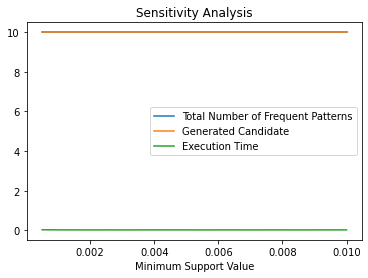

In [12]:
display_plot()